## Generate Result Tables
- MCHAD
- CAC
- II
- Center Loss
- G-MCHAD
- G-Center
- G-CAC

In [76]:
import seaborn as sb
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import pandas as pd
from os.path import join

In [77]:
sb.set()
sb.set_style("whitegrid")
sb.set_context("paper")

In [78]:
# root folder for experiment run
root = "/run/media/ki/292b6fa6-3ffb-4b84-9ed3-6bf879e10535/kirchhei/newmchad/finetune-tmp/agg/"

In [79]:
# map test cases
dataset_map = {
    "test_vs_uniformnoise": "Gauss",
    "test_vs_gaussiannoise": "Uniform",
    "test_vs_tinycrop": "Tiny Crop",
    "test_vs_tinyresize": "Tiny Resize",
    "test_vs_lsuncrop": "LSUN Crop",
    "test_vs_lsunresize": "LSUN Resize",
    "test_vs_textures": "Texture",
}

model_map = {
    "src.models.CAC": "CAC",
    "src.models.Softmax": "Softmax",
    "src.models.MCHAD": "MCHAD",
    "src.models.Center": "Center",
    "src.models.II": "II",
    "src.models.GCAC": "G-CAC",
    "src.models.GCenter": "G-Center",
}


train_dataset_map = {
    "src.datamodules.CIFAR10DataModule": "CIFAR10",
    "src.datamodules.SVHNDataModule": "SVHN",
    "src.datamodules.CIFAR100DataModule": "CIFAR100",
}

In [80]:
def convert(df, key="Distance", task="OSR"):
    """
    Get correct metrics from dataframe
    """
    df.rename(
        inplace=True,
        columns={
            "Accuracy/test": "Accuracy",
            f"{key}/{task}/AUROC/test": "AUROC",
            f"{key}/{task}/AUPR-IN/test": "AUPR-IN",
            f"{key}/{task}/AUPR-OUT/test": "AUPR-OUT",
            f"{key}/{task}/FPR@95TPR/test": "FPR95",
        },
    )

    return df

In [81]:
directories = []
directories += [f"./svhn/center/{i}" for i in range(21)]
directories += [f"./svhn/mchad/{i}" for i in range(21)]
directories += [f"./svhn/gmchad/{i}" for i in range(21)]
directories += [f"./svhn/gcenter/{i}" for i in range(21)]
directories += [f"./svhn/gcac/{i}" for i in range(21)]
directories += [f"./svhn/cac/{i}" for i in range(21)]
directories += [f"./svhn/ii/{i}" for i in range(21)]

directories += [f"./cifar100/mchad/{i}" for i in range(21)]
directories += [f"./cifar100/gmchad/{i}" for i in range(21)]
directories += [f"./cifar100/gcenter/{i}" for i in range(21)]
directories += [f"./cifar100/gcac/{i}" for i in range(21)]
directories += [f"./cifar100/cac/{i}" for i in range(21)]
directories += [f"./cifar100/ii/{i}" for i in range(21)]
directories += [f"./cifar100/center/{i}" for i in range(21)]


# del directories[directories.index("./cifar100/cac/13")]
directories += [f"./cifar10/mchad/{i}" for i in range(21)]
directories += [f"./cifar10/center/{i}" for i in range(21)]
directories += [f"./cifar10/gmchad/{i}" for i in range(21)]
directories += [f"./cifar10/gcenter/{i}" for i in range(21)]
directories += [f"./cifar10/gcac/{i}" for i in range(21)]
directories += [f"./cifar10/cac/{i}" for i in range(21)]
directories += [f"./cifar10/ii/{i}" for i in range(21)]

In [82]:


def get_training_set(datamodule):
    target = datamodule["_target_"]
    d = train_dataset_map.get(target)

    if not d:
        if target == "src.datamodules.MultiDatamodule":
            d = train_dataset_map.get(datamodule["module1"]["_target_"])

    if not d:
        print(datamodule)
    else:
        print(d)

    return d


def load(path):
    local_df = []

    df = pd.read_csv(join(path, "results.csv"))
    metrics = pd.read_csv(join(path, "csv/version_0/metrics.csv"))
    config = OmegaConf.load(join(path, "tb/version_0/hparams.yaml"))
    df["Dataset"] = get_training_set(config["datamodule"])
    df["Outliers"] = df["test_case_name"].apply(dataset_map.get)
    model = str(config["model"]["_target_"])

    if model == "src.models.CAC":
        df["Model"] = "CAC"
        df = convert(df, "Distance")
    elif model == "src.models.SoftMax":
        print("EB-OOD")
        df_ebm = df.copy(deep=True)
        df_ebm["Model"] = "EB-OOD"
        df_emb = convert(df_ebm, "EnergyBased")

        local_df.append(df_ebm)

        print("Softmax")
        df["Model"] = "Softmax"
        df = convert(df, "Softmax")

    elif model == "src.models.MCHAD":
        if config["model"]["weight_oe"] == 0.0:
            # print(f"Weight OE: {config['model']['weight_oe']}")
            df["Model"] = "MCHAD"
        else:
            print(f"Weight OE: {config['model']['weight_oe']}")
            df["Model"] = "G-MCHAD"

        df = convert(df)
    elif model == "src.models.Center":
        df["Model"] = "Center"
        df = convert(df, "Softmax")
    elif model == "src.models.IIModel":
        df["Model"] = "II"
        df = convert(df)
    elif model == "src.models.GCenter":
        df["Model"] = "G-Center"
        df = convert(df, key="Softmax")
    elif model == "src.models.GCAC":
        df["Model"] = "G-CAC"
        df = convert(df, key="Distance")
    else:
        raise Exception(f"UNKNOWN: {model}")

    local_df.append(df)
    return config, pd.concat(local_df), metrics

In [83]:
dfs = []

for d in directories:
    # filter(lambda x: "center" not in x and "cifar100/softmax/" not in x and "mchad-o" not in x, directories):
    path = join(root, d)
    config, df, metrics = load(path)
    try:
        if df is not None:
            print(path)
            print(
                f"{df['Dataset'][0]}/{df['Model'][0]} -> {df['AUROC'].mean()} {len(df)}"
            )
            df = df[
                [
                    "Accuracy",
                    "AUROC",
                    "AUPR-IN",
                    "AUPR-OUT",
                    "FPR95",
                    "Dataset",
                    "Outliers",
                    "Model",
                ]
            ]
            dfs.append(df.copy())
    except Exception as e:
        print("EXCEPTION WHILE LOADING")
        print(type(e), e)
        print(df.columns)

df = pd.concat(dfs)

SVHN
/run/media/ki/292b6fa6-3ffb-4b84-9ed3-6bf879e10535/kirchhei/newmchad/finetune-tmp/agg/./svhn/center/0
SVHN/Center -> 0.9665174910000393 8
SVHN
/run/media/ki/292b6fa6-3ffb-4b84-9ed3-6bf879e10535/kirchhei/newmchad/finetune-tmp/agg/./svhn/center/1
SVHN/Center -> 0.9663849898747036 8
SVHN
/run/media/ki/292b6fa6-3ffb-4b84-9ed3-6bf879e10535/kirchhei/newmchad/finetune-tmp/agg/./svhn/center/2
SVHN/Center -> 0.9753388251577105 8
SVHN
/run/media/ki/292b6fa6-3ffb-4b84-9ed3-6bf879e10535/kirchhei/newmchad/finetune-tmp/agg/./svhn/center/3
SVHN/Center -> 0.9637004051889692 8
SVHN
/run/media/ki/292b6fa6-3ffb-4b84-9ed3-6bf879e10535/kirchhei/newmchad/finetune-tmp/agg/./svhn/center/4
SVHN/Center -> 0.9660255142620632 8
SVHN
/run/media/ki/292b6fa6-3ffb-4b84-9ed3-6bf879e10535/kirchhei/newmchad/finetune-tmp/agg/./svhn/center/5
SVHN/Center -> 0.968406651701246 8
SVHN
/run/media/ki/292b6fa6-3ffb-4b84-9ed3-6bf879e10535/kirchhei/newmchad/finetune-tmp/agg/./svhn/center/6
SVHN/Center -> 0.9711302518844604 8


In [84]:
df["AUROC"] = df["AUROC"].apply(lambda x: x * 100)
df["AUPR-IN"] = df["AUPR-IN"].apply(lambda x: x * 100)
df["AUPR-OUT"] = df["AUPR-OUT"].apply(lambda x: x * 100)
df["FPR95"] = df["FPR95"].apply(lambda x: x * 100)
df["Accuracy"] = df["Accuracy"].apply(lambda x: x * 100)

In [85]:
# , "Tiny Crop", "LSUN Crop"
df = df[df["Outliers"].isin(["Texture", "Tiny Resize", "LSUN Resize", "Uniform", "Gaussian"])]
df = df.set_index(["Dataset", "Outliers", "Model"]).dropna()


In [86]:
from itertools import product
datasets = ["SVHN", "CIFAR10", "CIFAR100"]
# models = ["CAC", "II", "Center", "Softmax", "EB-OOD", "MCHAD", "G-MCHAD"]
models = ["MCHAD", "II", "CAC", "Center", "G-MCHAD", "G-Center", "G-CAC"]

t =  df.reset_index().groupby(by=["Dataset", "Model"]).agg(
        {
            "Accuracy": ["mean", "sem"],
            "AUROC": ["mean", "sem"],
            "AUPR-IN": ["mean", "sem"],
            "AUPR-OUT": ["mean", "sem"],
            "FPR95": ["mean", "sem"],
        }
    ).reindex(list(product(datasets, models)))

s = t.to_latex(
        float_format="%.2f",
        multirow=True,
        escape=False,
        label="tab:results",
        # bold_rows="True",
    )

repl = {
    "mean": "Mean",
    "sem": "$\\pm \sigma_{\\bar{x}}$",
    " MCHAD": " \\textbf{MCHAD (ours)}",
    "G-MCHAD": "\\textbf{G-MCHAD (ours)}",
    "G-Center": "\\textbf{G-Center (ours)}",
    "G-CAC": "\\textbf{G-CAC (ours)}",
}

for k, v in repl.items():
    s = s.replace(k, v)

print(s)

\begin{table}
\centering
\label{tab:results}
\begin{tabular}{llrrrrrrrrrr}
\toprule
         &       & \multicolumn{2}{l}{Accuracy} & \multicolumn{2}{l}{AUROC} & \multicolumn{2}{l}{AUPR-IN} & \multicolumn{2}{l}{AUPR-OUT} & \multicolumn{2}{l}{FPR95} \\
         &       &     Mean &  $\pm \sigma_{\bar{x}}$ &  Mean &  $\pm \sigma_{\bar{x}}$ &    Mean &  $\pm \sigma_{\bar{x}}$ &     Mean &  $\pm \sigma_{\bar{x}}$ &  Mean &  $\pm \sigma_{\bar{x}}$ \\
Dataset & Model &          &      &       &      &         &      &          &      &       &      \\
\midrule
\multirow{7}{*}{SVHN} & \textbf{MCHAD (ours)} &    96.31 & 0.01 & 97.96 & 0.10 &   99.33 & 0.04 &    92.81 & 0.37 & 10.10 & 0.78 \\
         & II &    12.03 & 0.25 & 48.86 & 1.70 &   75.04 & 1.05 &    27.07 & 1.26 & 93.09 & 1.23 \\
         & CAC &    93.38 & 0.05 & 95.57 & 0.22 &   97.88 & 0.14 &    86.91 & 0.61 & 19.71 & 1.64 \\
         & Center &    96.44 & 0.01 & 96.99 & 0.11 &   98.68 & 0.06 &    91.50 & 0.33 & 14.24 & 0.75 \\
  

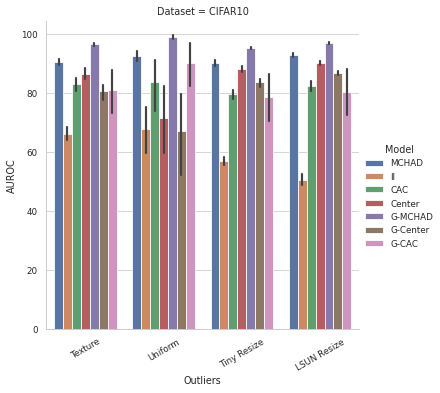

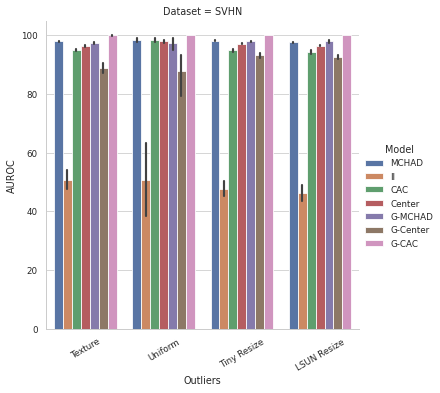

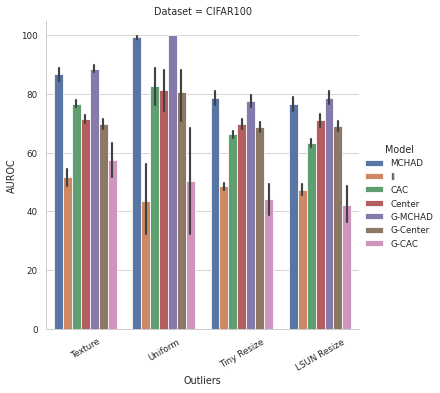

In [87]:
methods = ["MCHAD", "II", "CAC", "Center", "G-MCHAD", "G-Center", "G-CAC"]
# ,
for dataset in ["CIFAR10", "SVHN", "CIFAR100"]:
    g = sb.catplot(
        data=df.reset_index()[df.reset_index()["Dataset"] == dataset],
        x="Outliers",
        y="AUROC",
        kind="bar",
        hue="Model",
        col="Dataset",
        hue_order=methods
    )
    g.set_xticklabels(rotation=30)
    plt.savefig(f"out/single-auroc-{dataset}.png", dpi=300)
    plt.show()

In [88]:
tmp = df.reset_index().copy()
# tmp = tmp[(tmp["Model"] == "MCHAD") | (tmp["Model"] == "G-MCHAD")| (tmp["Model"] == "G-CAC") | (tmp["Model"] == "G-Center")]

print(
    tmp
    .groupby(by=["Dataset", "Model"])
    .agg(
        {
            "Accuracy": ["mean", "sem"],
            "AUROC": ["mean", "sem"],
            "AUPR-IN": ["mean", "sem"],
            "AUPR-OUT": ["mean", "sem"],
            "FPR95": ["mean", "sem"],
        }
    )
    .to_html(
        float_format="%.2f",
        escape=False,
    )
)


<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="2" halign="left">Accuracy</th>
      <th colspan="2" halign="left">AUROC</th>
      <th colspan="2" halign="left">AUPR-IN</th>
      <th colspan="2" halign="left">AUPR-OUT</th>
      <th colspan="2" halign="left">FPR95</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
    </tr>
    <tr>
      <th>Dataset</th>
      <th>Model</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="7" valign="top">CIFAR10</th>
      <th>CAC</th>
      <td>95.12</td>
      <td>0.02</td>
      <td>82.10</td>
      <td>1.23</td>
      <td>8

In [89]:
tmp.groupby(by=["Dataset", "Model"]).agg(
    {
        "Accuracy": ["mean", "sem"],
        "AUROC": ["mean", "sem"],
        "AUPR-IN": ["mean", "sem"],
        "AUPR-OUT": ["mean", "sem"],
        "FPR95": ["mean", "sem"],
    }
)

Accuracy                AUROC              AUPR-IN  \
                        mean       sem       mean       sem       mean   
Dataset  Model                                                           
CIFAR10  CAC       95.123809  0.015447  82.103495  1.228222  81.678112   
         Center    94.625714  0.015159  84.065616  1.703271  85.112480   
         G-CAC     67.928096  3.148705  82.451252  2.025391  82.534386   
         G-Center  94.655714  0.014888  79.458936  1.990169  75.767482   
         G-MCHAD   95.066667  0.020522  96.919207  0.193633  97.804735   
         II        40.043810  0.318312  60.192490  1.338773  64.828723   
         MCHAD     95.117143  0.014288  91.545385  0.321219  93.577415   
CIFAR100 CAC       74.741905  0.065541  72.231831  1.252677  76.710975   
         Center    76.063809  0.020645  73.412829  1.131170  76.455423   
         G-CAC     20.880476  2.241344  48.556823  2.694421  56.387409   
         G-Center  75.239524  0.027753  72.083281  1.252770  74.587425   
         G-MCHAD   73.849047  0.180900  86.200062  1.072817  87.503700   
         II         6.385238  0.105767  47.724685  1.590504  54.484609   
         MCHAD     76.259047  0.030351  85.326743  1.104030  87.575899   
SVHN     CAC       93.381772  0.049536  95.573204  0.224004  97.882600   
         Center    96.440461  0.009450  96.985265  0.111799  98.684508   
         G-CAC     91.870079  0.133984  99.982360  0.006768  99.994258   
         G-Center  96.373511  0.009037  90.586140  0.985030  93.390478   
         G-MCHAD   96.257720  0.014541  97.642677  0.270096  99.246575   
         II        12.030431  0.250508  48.859865  1.697410  75.042797   
         MCHAD     96.309121  0.012049  97.957826  0.103070  99.334661   

                              AUPR-OUT                FPR95            
                        sem       mean       sem       mean       sem  
Dataset  Model                                                         
CIFAR10  CAC       1.204178  78.332679  1.037706  64.971906  2.322773  
         Center    1.473833  80.154984  1.501255  60.473375  2.149180  
         G-CAC     2.108891  81.338709  2.070936  42.982081  3.891249  
         G-Center  1.475289  78.270580  1.477444  62.264479  1.678163  
         G-MCHAD   0.152154  95.131110  0.357161  19.883602  1.607448  
         II        1.531320  54.590833  1.054591  90.200059  1.314250  
         MCHAD     0.327752  86.160908  0.699221  52.189361  2.425139  
CIFAR100 CAC       1.318527  66.177837  1.258370  78.821415  2.352413  
         Center    1.186208  67.883789  1.343588  76.028437  2.253195  
         G-CAC     2.113178  51.834134  2.025066  82.436298  2.858154  
         G-Center  1.278613  66.798429  1.332053  77.597526  2.146966  
         G-MCHAD   1.073723  85.182454  1.099821  44.506198  3.254841  
         II        1.357610  45.659759  1.127227  94.975109  0.777978  
         MCHAD     1.029214  82.504984  1.253714  50.372078  3.430953  
SVHN     CAC       0.137949  86.907723  0.607082  19.711668  1.640271  
         Center    0.060866  91.495332  0.328970  14.235688  0.750072  
         G-CAC     0.002597  99.952630  0.010472   0.053489  0.016365  
         G-Center  0.578422  79.659265  1.097835  32.656968  1.517941  
         G-MCHAD   0.082485  92.494372  0.897054  14.226300  1.719379  
         II        1.048364  27.074761  1.259344  93.092132  1.232328  
         MCHAD     0.037427  92.808953  0.374333  10.100206  0.781509

In [90]:
from scipy.stats import ttest_ind

tmp = df.reset_index().copy()
# tmp = tmp[(tmp["Model"] == "MCHAD") | (tmp["Model"] == "G-MCHAD")]

for metric in ["Accuracy", "AUROC", "AUPR-IN", "AUPR-OUT", "FPR95"]:
    for dataset in ["SVHN", "CIFAR10", "CIFAR100"]:
        a = tmp[(tmp["Model"] == "CAC") & (tmp["Dataset"] == dataset)][metric]
        b = tmp[(tmp["Model"] == "MCHAD") & (tmp["Dataset"]== dataset)][metric]
        stat, p = ttest_ind(a,b, equal_var=False)
        print(f"{metric} {dataset} -> {p < 0.05} ")

Accuracy SVHN -> True 
Accuracy CIFAR10 -> False 
Accuracy CIFAR100 -> True 
AUROC SVHN -> True 
AUROC CIFAR10 -> True 
AUROC CIFAR100 -> True 
AUPR-IN SVHN -> True 
AUPR-IN CIFAR10 -> True 
AUPR-IN CIFAR100 -> True 
AUPR-OUT SVHN -> True 
AUPR-OUT CIFAR10 -> True 
AUPR-OUT CIFAR100 -> True 
FPR95 SVHN -> True 
FPR95 CIFAR10 -> True 
FPR95 CIFAR100 -> True 
